# ResNet-18 Model

### Importing Required Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.datasets import DTD
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Hyperparameter Tuning

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_set = DTD("data", split="train", download=True, transform=train_transform)
val_set   = DTD("data", split="val",   transform=val_transform)

num_classes = len(train_set.classes)
batch_size = 64
epochs_per_config = 5

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2)

def get_activation_fn(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "leaky_relu":
        return nn.LeakyReLU(0.1)
    if name == "tanh":
        return nn.Tanh()
    if name == "sigmoid":
        return nn.Sigmoid()
    raise ValueError(f"Unknown activation: {name}")

def create_optimizer(model, optimizer_name: str, learning_rate: float, weight_decay: float):
    optimizer_name = optimizer_name.lower()
    if optimizer_name == "adam":
        return torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    if optimizer_name == "sgd":
        return torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    if optimizer_name == "adamw":
        return torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    raise ValueError(f"Unknown optimizer: {optimizer_name}")

def compute_accuracy(model, data_loader):
    model.eval()
    all_labels, all_predictions = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            predictions = logits.argmax(dim=1)
            all_labels.append(labels.cpu())
            all_predictions.append(predictions.cpu())
    all_labels = torch.cat(all_labels).numpy()
    all_predictions = torch.cat(all_predictions).numpy()
    return accuracy_score(all_labels, all_predictions)

optimizer_options = ["adam", "sgd", "adamw"]
learning_rate_options = [1e-3, 3e-4]
dropout_options = [0.0, 0.3]
activation_options = ["relu", "leaky_relu", "tanh", "sigmoid"]

best_val_accuracy = 0.0
best_hyperparams = None
config_index = 0

for opt_name in optimizer_options:
    for lr in learning_rate_options:
        for dropout_prob in dropout_options:
            for act_name in activation_options:
                config_index += 1
                print(f"\nConfig {config_index}: optimizer={opt_name}, lr={lr}, dropout={dropout_prob}, activation={act_name}")

                model = models.resnet18(weights=None)
                activation_layer = get_activation_fn(act_name)
                model.fc = nn.Sequential(
                    nn.Dropout(dropout_prob),
                    activation_layer,
                    nn.Linear(model.fc.in_features, num_classes)
                )
                model = model.to(device)

                optimizer = create_optimizer(model, opt_name, lr, weight_decay=1e-4)
                loss_fn = nn.CrossEntropyLoss()

                for epoch in range(1, epochs_per_config + 1):
                    model.train()
                    for images, labels in train_loader:
                        images = images.to(device)
                        labels = labels.to(device)
                        optimizer.zero_grad()
                        logits = model(images)
                        loss = loss_fn(logits, labels)
                        loss.backward()
                        optimizer.step()

                    val_accuracy = compute_accuracy(model, val_loader)
                    print(f"Epoch {epoch}/{epochs_per_config} - Val Accuracy: {val_accuracy:.3f}")

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_hyperparams = {
                        "optimizer": opt_name,
                        "learning_rate": lr,
                        "dropout": dropout_prob,
                        "activation": act_name,
                    }

print("\nBest configuration based on validation accuracy:")
print("Optimizer :", best_hyperparams["optimizer"])
print("Learning rate :", best_hyperparams["learning_rate"])
print("Dropout :", best_hyperparams["dropout"])
print("Activation :", best_hyperparams["activation"])
print("Best Val Acc :", round(best_val_accuracy, 3))


Config 1: optimizer=adam, lr=0.001, dropout=0.0, activation=relu
Epoch 1/5 - Val Accuracy: 0.025
Epoch 2/5 - Val Accuracy: 0.078
Epoch 3/5 - Val Accuracy: 0.065
Epoch 4/5 - Val Accuracy: 0.084
Epoch 5/5 - Val Accuracy: 0.081

Config 2: optimizer=adam, lr=0.001, dropout=0.0, activation=leaky_relu
Epoch 1/5 - Val Accuracy: 0.038
Epoch 2/5 - Val Accuracy: 0.057
Epoch 3/5 - Val Accuracy: 0.046
Epoch 4/5 - Val Accuracy: 0.079
Epoch 5/5 - Val Accuracy: 0.066

Config 3: optimizer=adam, lr=0.001, dropout=0.0, activation=tanh
Epoch 1/5 - Val Accuracy: 0.036
Epoch 2/5 - Val Accuracy: 0.068
Epoch 3/5 - Val Accuracy: 0.080
Epoch 4/5 - Val Accuracy: 0.079
Epoch 5/5 - Val Accuracy: 0.076

Config 4: optimizer=adam, lr=0.001, dropout=0.0, activation=sigmoid
Epoch 1/5 - Val Accuracy: 0.022
Epoch 2/5 - Val Accuracy: 0.037
Epoch 3/5 - Val Accuracy: 0.047
Epoch 4/5 - Val Accuracy: 0.042
Epoch 5/5 - Val Accuracy: 0.049

Config 5: optimizer=adam, lr=0.001, dropout=0.3, activation=relu
Epoch 1/5 - Val Accur

### Final Training

100%|██████████| 625M/625M [00:46<00:00, 13.4MB/s]


Training ResNet-18 with best hyperparameters:
Epoch 1/50 - LR: 3.0e-04 - Train Acc: 0.068 - Test Acc: 0.071
Epoch 2/50 - LR: 3.0e-04 - Train Acc: 0.118 - Test Acc: 0.116
Epoch 3/50 - LR: 3.0e-04 - Train Acc: 0.125 - Test Acc: 0.121
Epoch 4/50 - LR: 3.0e-04 - Train Acc: 0.100 - Test Acc: 0.095
Epoch 5/50 - LR: 3.0e-04 - Train Acc: 0.150 - Test Acc: 0.130
Epoch 6/50 - LR: 3.0e-04 - Train Acc: 0.151 - Test Acc: 0.145
Epoch 7/50 - LR: 3.0e-04 - Train Acc: 0.146 - Test Acc: 0.136
Epoch 8/50 - LR: 3.0e-04 - Train Acc: 0.174 - Test Acc: 0.152
Epoch 9/50 - LR: 3.0e-04 - Train Acc: 0.204 - Test Acc: 0.165
Epoch 10/50 - LR: 3.0e-04 - Train Acc: 0.238 - Test Acc: 0.210
Epoch 11/50 - LR: 3.0e-04 - Train Acc: 0.231 - Test Acc: 0.202
Epoch 12/50 - LR: 3.0e-04 - Train Acc: 0.173 - Test Acc: 0.158
Epoch 13/50 - LR: 3.0e-04 - Train Acc: 0.317 - Test Acc: 0.263
Epoch 14/50 - LR: 3.0e-04 - Train Acc: 0.289 - Test Acc: 0.237
Epoch 15/50 - LR: 3.0e-04 - Train Acc: 0.283 - Test Acc: 0.241
Epoch 16/50 - LR: 

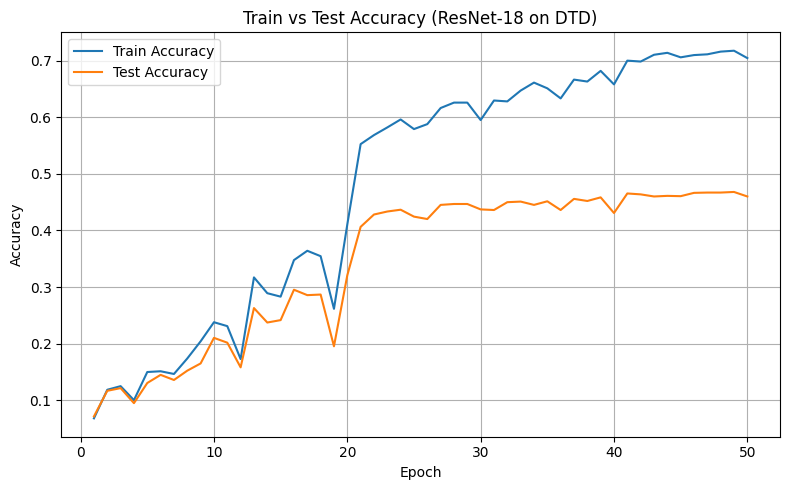


Classification Report (per-class Precision, Recall, F1):

              precision    recall  f1-score   support

      banded       0.68      0.75      0.71        40
     blotchy       0.11      0.05      0.07        40
     braided       0.20      0.25      0.22        40
      bubbly       0.46      0.47      0.47        40
       bumpy       0.26      0.30      0.28        40
   chequered       0.72      0.82      0.77        40
   cobwebbed       0.66      0.78      0.71        40
     cracked       0.57      0.57      0.57        40
crosshatched       0.44      0.35      0.39        40
 crystalline       0.43      0.65      0.51        40
      dotted       0.59      0.57      0.58        40
     fibrous       0.47      0.47      0.47        40
     flecked       0.50      0.45      0.47        40
    freckled       0.64      0.70      0.67        40
      frilly       0.45      0.53      0.48        40
       gauzy       0.53      0.65      0.58        40
        grid       0.4

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_set = DTD("data", split="train", download=True, transform=train_transform)
val_set   = DTD("data", split="val",   transform=train_transform)
test_set  = DTD("data", split="test",  transform=test_transform)

num_classes = len(train_set.classes)
class_names = train_set.classes

batch_size = 64
num_epochs = 50

trainval_set = ConcatDataset([train_set, val_set])
trainval_loader = DataLoader(trainval_set, batch_size=batch_size,
                             shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size,
                         shuffle=False, num_workers=2)

def get_activation_fn(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "leaky_relu":
        return nn.LeakyReLU(0.1)
    if name == "tanh":
        return nn.Tanh()
    if name == "sigmoid":
        return nn.Sigmoid()
    raise ValueError(f"Unknown activation: {name}")

def build_resnet18(num_classes: int, dropout_prob: float, activation_name: str):
    model = models.resnet18(weights=None)
    model.fc = nn.Sequential(
        nn.Dropout(dropout_prob),
        get_activation_fn(activation_name),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model

def get_predictions(model, data_loader):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    return all_labels, all_preds

def evaluate_accuracy(model, data_loader):
    labels, preds = get_predictions(model, data_loader)
    return accuracy_score(labels, preds)

optimizer_name   = "adam"
learning_rate    = 3e-4
dropout_prob     = 0.0
activation_name  = "relu"

model = build_resnet18(num_classes, dropout_prob, activation_name).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

train_acc_history = []
test_acc_history = []

print("Training ResNet-18 with best hyperparameters:")
for epoch in range(1, num_epochs + 1):
    model.train()
    for images, labels in trainval_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

    scheduler.step()

    train_acc = evaluate_accuracy(model, trainval_loader)
    test_acc  = evaluate_accuracy(model, test_loader)
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch}/{num_epochs} - LR: {current_lr:.1e} - Train Acc: {train_acc:.3f} - Test Acc: {test_acc:.3f}")

test_labels, test_preds = get_predictions(model, test_loader)
final_test_acc = accuracy_score(test_labels, test_preds)
print("\nFinal Test Accuracy:", round(final_test_acc, 3))

torch.save(model.state_dict(), "resnet18_dtd_best.pth")
print("Saved the trained model")

epochs_axis = np.arange(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_axis, train_acc_history, label="Train Accuracy")
plt.plot(epochs_axis, test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (ResNet-18 on DTD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nClassification Report (per-class Precision, Recall, F1):\n")
print(classification_report(test_labels, test_preds, target_names=class_names, zero_division=0))

### Evaluation Metrics

In [3]:
overall_acc = accuracy_score(test_labels, test_preds)
overall_prec = precision_score(test_labels, test_preds, average="macro", zero_division=0)
overall_rec  = recall_score(test_labels, test_preds, average="macro", zero_division=0)
overall_f1   = f1_score(test_labels, test_preds, average="macro", zero_division=0)

print("Overall Accuracy:", round(overall_acc, 4))
print("Precision:", round(overall_prec, 4))
print("Recall:", round(overall_rec, 4))
print("F1 Score:", round(overall_f1, 4))

Overall Accuracy: 0.4601
Precision: 0.4566
Recall: 0.4601
F1 Score: 0.4542


### Confusion Matrix

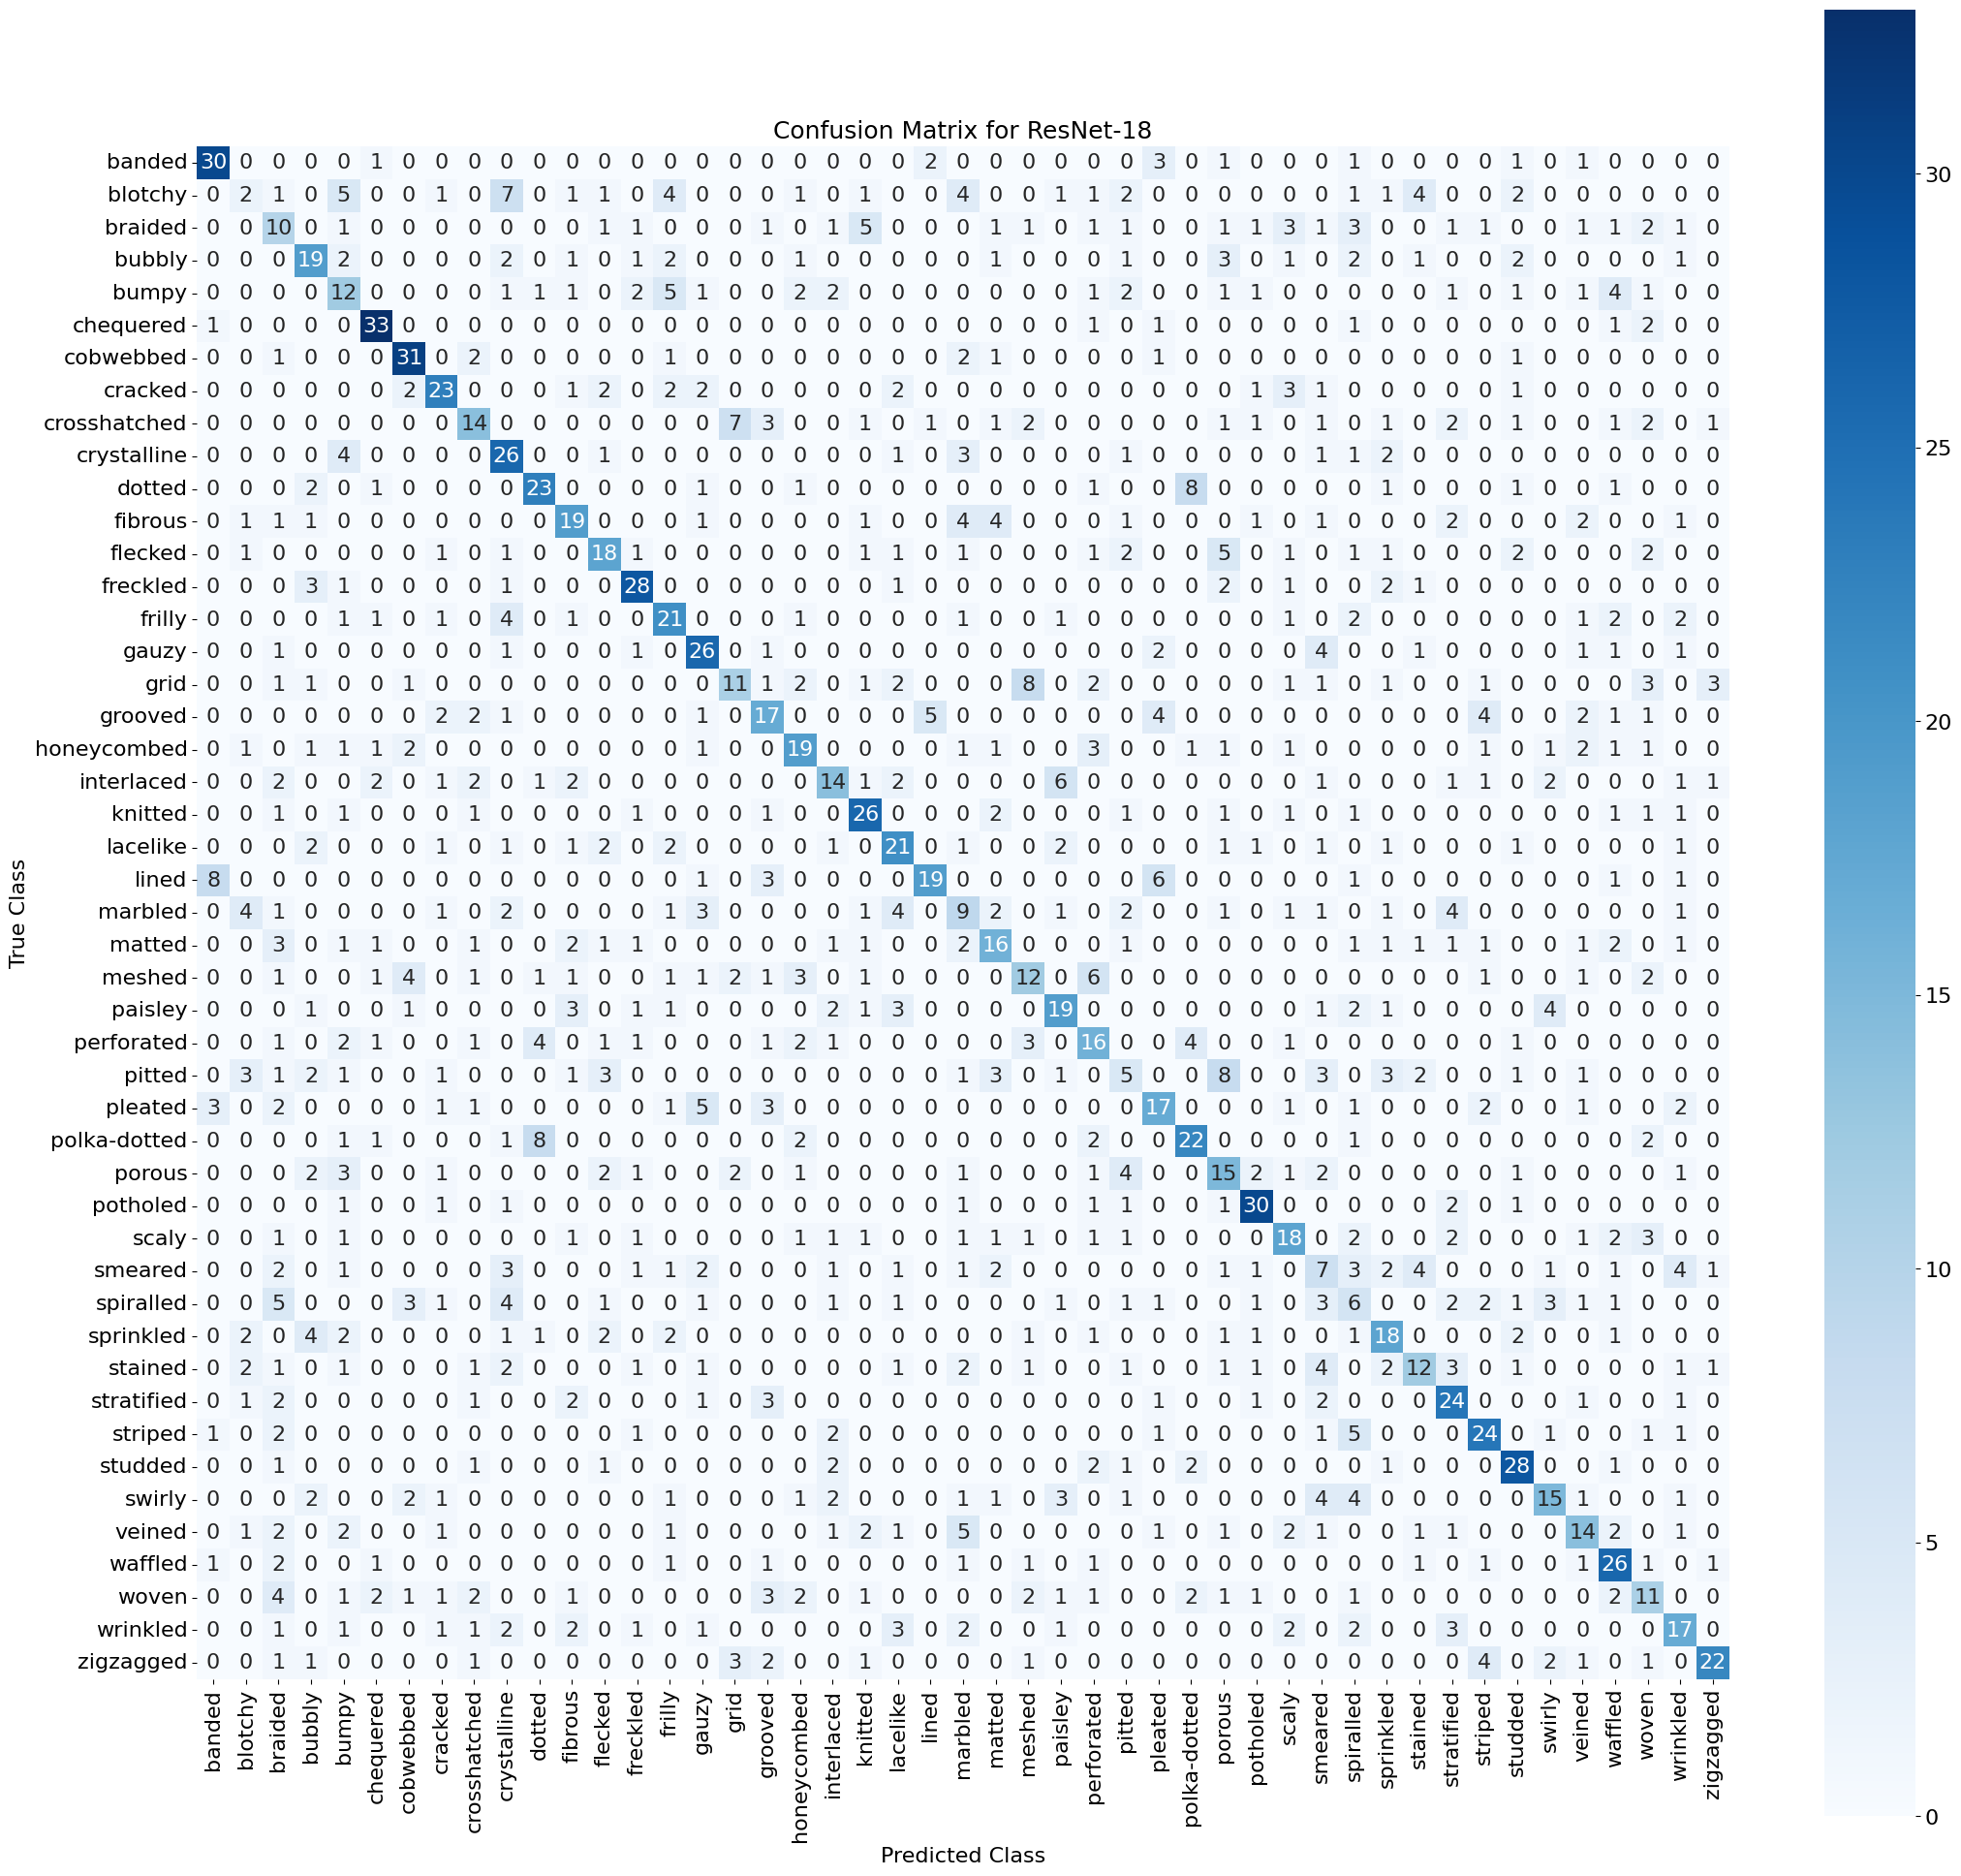

In [14]:
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(22, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    square=True,
    cbar=True,
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 16}
)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.title("Confusion Matrix for ResNet-18", fontsize=18)
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("True Class", fontsize=16)
plt.tight_layout()
plt.show()